In [208]:
from config import POSTGRES_CONNECTION_STRING
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import haversine
import random
import math
from IPython.display import clear_output
import json

In [2]:
def con():
    return create_engine(POSTGRES_CONNECTION_STRING)

In [14]:
szs = pd.read_sql('''
    select sz.id as id, obj.lat as lat, obj.lng as lng, px.radius as radius, sz.square as square
    from sportzones as sz
    join objects as obj
        on obj.id = sz.object_id
    join proximity as px
        on px.id = obj.proximity_id
''', con())
print(szs.shape)
szs.head()

(26238, 5)


,id,lat,lng,radius,square
0,1042887,55.81508,37.559064,500,569.5
1,1042886,55.81508,37.559064,500,216.0
2,1042888,55.81508,37.559064,500,216.0
3,1042889,55.81508,37.559064,500,180.0
4,1042890,55.81508,37.559064,500,180.0


In [16]:
(min_lat, min_lng), (max_lat, max_lng) = np.load('map-borders.npy')

In [61]:
center_lat = (max_lat - min_lat) / 2
center_lng = (max_lng - min_lng) / 2

In [160]:
def plot_sportzone_available_square(size):
    hm = np.zeros((size, size))
    lat_step = (max_lat - min_lat) / size
    lng_step = (max_lng - min_lng) / size
    for sz in szs.values:
        lat = sz[1]
        lng = sz[2]
        radius = sz[3]
        square = sz[4]

        rect_min_lat = haversine.inverse_haversine((lat, lng), radius / 1000, haversine.Direction.SOUTH)[0]
        rect_min_lng = haversine.inverse_haversine((lat, lng), radius / 1000, haversine.Direction.WEST)[1]
        rect_max_lat = haversine.inverse_haversine((lat, lng), radius / 1000, haversine.Direction.NORTH)[0]
        rect_max_lng = haversine.inverse_haversine((lat, lng), radius / 1000, haversine.Direction.EAST)[1]

        rect_min_lat_index = int((rect_min_lat - min_lat) / lat_step + 0.5)
        rect_min_lng_index = int((rect_min_lng - min_lng) / lng_step + 0.5)
        rect_max_lat_index = int((rect_max_lat - min_lat) / lat_step + 0.5)
        rect_max_lng_index = int((rect_max_lng - min_lng) / lng_step + 0.5)

        h = rect_max_lat_index - rect_min_lat_index + 1
        w = rect_max_lng_index - rect_min_lng_index + 1
        for i in range(rect_min_lat_index, rect_max_lat_index + 1):
            for j in range(rect_min_lng_index, rect_max_lng_index + 1):
                di = 2 * (i - rect_min_lat_index) + 1 - h
                dj = 2 * (j - rect_min_lng_index) + 1 - w
                if (w * di) ** 2 + (h * dj) ** 2 <= (w * h) ** 2:
                    hm[i, j] += square

    plt.figure(figsize=(14, 18))
    sns.heatmap(np.log1p(hm), cbar=False)
    plt.gca().invert_yaxis()
    plt.show()

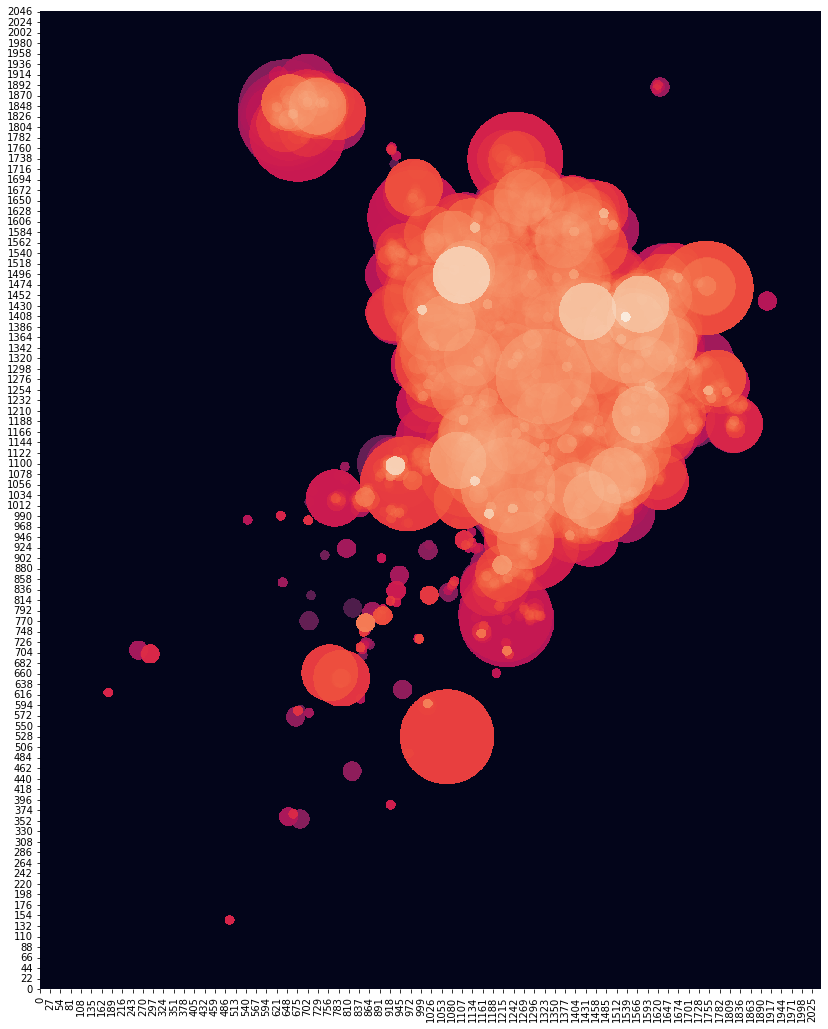

CPU times: user 1min 8s, sys: 500 ms, total: 1min 9s
Wall time: 1min 9s


In [161]:
%%time
plot_sportzone_available_square(size=2048)

In [175]:
def precalculate_sportzone_circle(size, lat, lng, radius, square):
    lat_step = (max_lat - min_lat) / size
    lng_step = (max_lng - min_lng) / size
    rect_min_lat = haversine.inverse_haversine((lat, lng), radius / 1000, haversine.Direction.SOUTH)[0]
    rect_min_lng = haversine.inverse_haversine((lat, lng), radius / 1000, haversine.Direction.WEST)[1]
    rect_max_lat = haversine.inverse_haversine((lat, lng), radius / 1000, haversine.Direction.NORTH)[0]
    rect_max_lng = haversine.inverse_haversine((lat, lng), radius / 1000, haversine.Direction.EAST)[1]

    rect_min_lat_index = int((rect_min_lat - min_lat) / lat_step + 0.5)
    rect_min_lng_index = int((rect_min_lng - min_lng) / lng_step + 0.5)
    rect_max_lat_index = int((rect_max_lat - min_lat) / lat_step + 0.5)
    rect_max_lng_index = int((rect_max_lng - min_lng) / lng_step + 0.5)

    h = rect_max_lat_index - rect_min_lat_index + 1
    w = rect_max_lng_index - rect_min_lng_index + 1
    hm = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            di = 2 * i + 1 - h
            dj = 2 * j + 1 - w
            if (w * di) ** 2 + (h * dj) ** 2 <= (w * h) ** 2:
                hm[i, j] = square
    return (rect_min_lat_index, rect_min_lng_index), hm

In [182]:
sz = szs.iloc[0]
shift_8192, matrix_8192 = precalculate_sportzone_circle(8192, sz['lat'], sz['lng'], sz['radius'], sz['square'])

(5835, 4960)


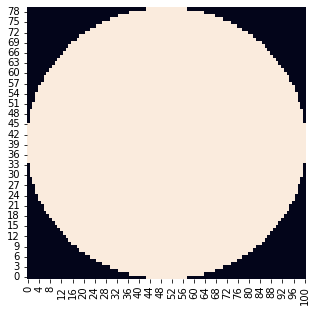

In [209]:
print(shift_8192)
plt.figure(figsize=(5, 5))
sns.heatmap(matrix_8192, cbar=False)
plt.gca().invert_yaxis()
plt.show()

In [196]:
def resize_heatmap_piece(shift, matrix, k):
    i1 = shift[0]
    j1 = shift[1]
    i2 = i1 + matrix.shape[0] - 1
    j2 = j1 + matrix.shape[1] - 1
    i1_pad = i1 % k
    j1_pad = j1 % k
    i2_pad = (k - 1) - i2 % k
    j2_pad = (k - 1) - j2 % k
    m = matrix
    if i1_pad != 0:
        m = np.concatenate([np.zeros((i1_pad, m.shape[1])), m], axis=0)
        i1 -= i1_pad
    if j1_pad != 0:
        m = np.concatenate([np.zeros((m.shape[0], j1_pad)), m], axis=1)
        j1 -= j1_pad
    if i2_pad != 0:
        m = np.concatenate([m, np.zeros((i2_pad, m.shape[1]))], axis=0)
        i2 += i2_pad
    if j2_pad != 0:
        m = np.concatenate([m, np.zeros((m.shape[0], j2_pad))], axis=1)
        j2 += j2_pad
    res_i1 = i1 // k
    res_j1 = j1 // k
    res_i2 = i2 // k
    res_j2 = j2 // k
    res_matrix = np.zeros((res_i2 - res_i1 + 1, res_j2 - res_j1 + 1))
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            res_matrix[i // k, j // k] += m[i, j]
    res_matrix /= k * k
    
    return (res_i1, res_j1), res_matrix

In [197]:
shift_2048, matrix_2048 = resize_heatmap_piece(shift_8192, matrix_8192, 4)

(1458, 1240)


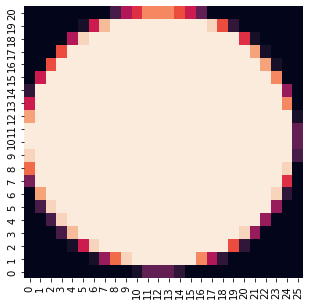

In [201]:
print(shift_2048)
plt.figure(figsize=(5, 5))
sns.heatmap(matrix_2048, cbar=False)
plt.gca().invert_yaxis()
plt.show()

(729, 620)


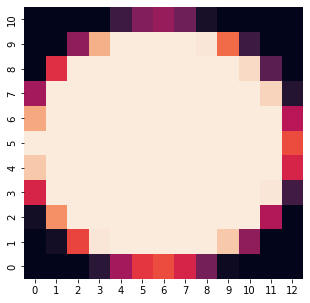

In [202]:
shift_1024, matrix_1024 = resize_heatmap_piece(shift_2048, matrix_2048, 2)
print(shift_1024)
plt.figure(figsize=(5, 5))
sns.heatmap(matrix_1024, cbar=False)
plt.gca().invert_yaxis()
plt.show()

(364, 310)


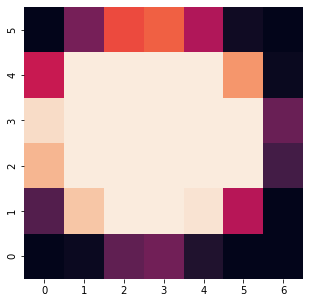

In [203]:
shift_512, matrix_512 = resize_heatmap_piece(shift_1024, matrix_1024, 2)
print(shift_512)
plt.figure(figsize=(5, 5))
sns.heatmap(matrix_512, cbar=False)
plt.gca().invert_yaxis()
plt.show()

(182, 155)


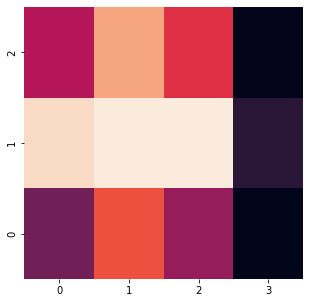

In [204]:
shift_256, matrix_256 = resize_heatmap_piece(shift_512, matrix_512, 2)
print(shift_256)
plt.figure(figsize=(5, 5))
sns.heatmap(matrix_256, cbar=False)
plt.gca().invert_yaxis()
plt.show()

(91, 77)


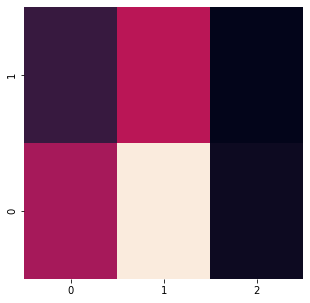

In [205]:
shift_128, matrix_128 = resize_heatmap_piece(shift_256, matrix_256, 2)
print(shift_128)
plt.figure(figsize=(5, 5))
sns.heatmap(matrix_128, cbar=False)
plt.gca().invert_yaxis()
plt.show()

(45, 38)


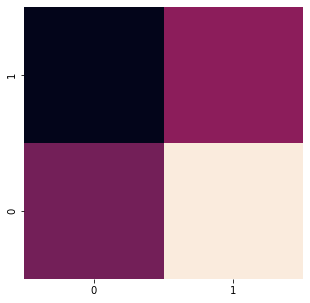

In [206]:
shift_64, matrix_64 = resize_heatmap_piece(shift_128, matrix_128, 2)
print(shift_64)
plt.figure(figsize=(5, 5))
sns.heatmap(matrix_64, cbar=False)
plt.gca().invert_yaxis()
plt.show()

(22, 19)


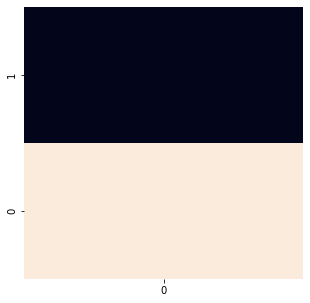

In [207]:
shift_32, matrix_32 = resize_heatmap_piece(shift_64, matrix_64, 2)
print(shift_32)
plt.figure(figsize=(5, 5))
sns.heatmap(matrix_32, cbar=False)
plt.gca().invert_yaxis()
plt.show()

In [217]:
%%time
connection = con()
for cnt, (_, sz) in enumerate(szs.iterrows()):
    clear_output(wait=True)
    print(cnt)
    shift_8192, matrix_8192 = precalculate_sportzone_circle(
        8192, sz['lat'], sz['lng'], sz['radius'], sz['square']
    )
    shift_2048, matrix_2048 = resize_heatmap_piece(shift_8192, matrix_8192, 4)
    shift_1024, matrix_1024 = resize_heatmap_piece(shift_2048, matrix_2048, 2)
    shift_512, matrix_512 = resize_heatmap_piece(shift_1024, matrix_1024, 2)
    shift_256, matrix_256 = resize_heatmap_piece(shift_512, matrix_512, 2)
    shift_128, matrix_128 = resize_heatmap_piece(shift_256, matrix_256, 2)
    shift_64, matrix_64 = resize_heatmap_piece(shift_128, matrix_128, 2)
    shift_32, matrix_32 = resize_heatmap_piece(shift_64, matrix_64, 2)
    df = pd.DataFrame({
        'size': [2048, 1024, 512, 256, 128, 64, 32],
        'vert_index': [
            shift_2048[0],
            shift_1024[0],
            shift_512[0],
            shift_256[0],
            shift_128[0],
            shift_64[0],
            shift_32[0]
        ],
        'horz_index': [
            shift_2048[1],
            shift_1024[1],
            shift_512[1],
            shift_256[1],
            shift_128[1],
            shift_64[1],
            shift_32[1]
        ],
        'height': [
            matrix_2048.shape[0],
            matrix_1024.shape[0],
            matrix_512.shape[0],
            matrix_256.shape[0],
            matrix_128.shape[0],
            matrix_64.shape[0],
            matrix_32.shape[0]
        ],
        'width': [
            matrix_2048.shape[1],
            matrix_1024.shape[1],
            matrix_512.shape[1],
            matrix_256.shape[1],
            matrix_128.shape[1],
            matrix_64.shape[1],
            matrix_32.shape[1]
        ],
        'matrix': [
            json.dumps(matrix_2048.tolist()),
            json.dumps(matrix_1024.tolist()),
            json.dumps(matrix_512.tolist()),
            json.dumps(matrix_256.tolist()),
            json.dumps(matrix_128.tolist()),
            json.dumps(matrix_64.tolist()),
            json.dumps(matrix_32.tolist())
        ]
    })
    df['sportzone_id'] = sz['id']
    df.to_sql('sportzone_density_matrixes', connection, index=False, if_exists='append')

26237
CPU times: user 34min 20s, sys: 50.6 s, total: 35min 11s
Wall time: 1h 19min 5s
